In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from plot_functions import *
from sklearn.model_selection import KFold

from create_matrix import *

from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "SanDiego"
year = 2014

import os


def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

n_splits = 10
import sys
case=2
a=2
cost='abs'

def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [2]:
df, dfc = create_matrix_single_region("SanDiego", year)
tensor = get_tensor(df, dfc)

In [10]:
np.random.seed(0)
lr = 0.1
decay_mul = 1
num_iter = 10
E_np_masked = tensor
cost_function = 'fraction'
H_known=None
A_known=None
T_known=None
batchsize=None
aggregate_constraint=False
dis=True
lrs = lr*np.power(decay_mul, range(num_iter))
if cost_function == 'abs':
    cost = cost_abs
elif cost_function =='rel':
    cost = cost_rel
elif cost_function =='fraction':
    cost = cost_fraction
mg = multigrad(cost, argnums=[0, 1, 2])

params = {}
params['M'], params['N'], params['O'] = E_np_masked.shape
params['a'] = a
params['b'] = b
H_dim_chars = list(cases[case]['HA'].split(",")[0].strip())
H_dim = tuple(params[x] for x in H_dim_chars)
A_dim_chars = list(cases[case]['HA'].split(",")[1].split("-")[0].strip())
A_dim = tuple(params[x] for x in A_dim_chars)
T_dim_chars = list(cases[case]['HAT'].split(",")[1].split("-")[0].strip())
T_dim = tuple(params[x] for x in T_dim_chars)
H = np.abs(np.random.rand(*H_dim))

A = np.abs(np.random.rand(*A_dim))
T = np.abs(np.random.rand(*T_dim))

In [90]:
print cost_fraction2(H, A, T, E_np_masked, 2)
print cost_abs(H, A, T, E_np_masked, 2)
print cost_rel(H, A, T, E_np_masked, 2)

240.800270801
198.616759517
21.3136249546


In [80]:
multigrad(cost_fraction, argnums=[0, 1, 2])(H, A, T, E_np_masked, case)[0]

array([[        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [ 0.00581763,  0.00592227],
       [        nan,         nan],
       [ 0.01589464,  0.01600831],
       [        nan,         nan],
       [        nan,         nan],
       [ 0.00740613,  0.00749264],
       [ 0.01262322,  0.01277383],
       [        nan,         nan],
       [ 0.14719393,  0.14948436],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [ 0.06752103,  0.06916609],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [ 0.15115079,  0.15258234],
       [        nan,         nan],
       [ 0.03818583,  0.039191  ],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [ 0.01060625,  0.01070638],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,

In [89]:
multigrad(cost_fraction2, argnums=[0, 1, 2])(H, A, T, E_np_masked, case)[0]

array([[ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan]])

In [9]:
if batchsize is None:
    batchsize = len(E_np_masked)

indices_home = range(params['M'])


# GD procedure
for i in range(num_iter):
    if batchsize < len(E_np_masked):
        indices_select = np.random.choice(indices_home, batchsize)
        del_h, del_a, del_t = mg(H[indices_select], A, T, E_np_masked[indices_select], case)
        H[indices_select] -= lrs[i] * del_h
    else:
        del_h, del_a, del_t = mg(H, A, T, E_np_masked, case)
        H -= lrs[i] * del_h
    A -= lrs[i] * del_a
    T -= lrs[i] * del_t
    # Projection to known values
    if H_known is not None:
        H = set_known(H, H_known)
    if A_known is not None:
        A = set_known(A, A_known)
    if T_known is not None:
        T = set_known(T, T_known)
    # Projection to non-negative space
    H[H < 0] = 0
    A[A < 0] = 0
    T[T < 0] = 0

    if aggregate_constraint:
        # Projection to ensure A[aggregate] >=sum(A[appliances]
        A[0] = np.maximum(A[0], np.sum(A[1:], axis=0))

    if i % 500 == 0:
        if dis:
            print(cost(H, A, T, E_np_masked, case), lrs[i], i)       

(nan, 0.10000000000000001, 0)


/Users/nipunbatra/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in less
/Users/nipunbatra/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in less
/Users/nipunbatra/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in less


In [4]:
H, A, T = learn_HAT(case, tensor, a, a, num_iter=2900, lr=0.1, dis=True, cost_function='rel', batchsize=None, aggregate_constraint=True)


(0.8382282405837751, 0.10000000000000001, 0)
(0.81297955650473253, 0.10000000000000001, 500)
(0.79015388447577806, 0.10000000000000001, 1000)
(0.76965250045352007, 0.10000000000000001, 1500)
(0.75479774366111196, 0.10000000000000001, 2000)
(0.74325055905027038, 0.10000000000000001, 2500)


In [12]:
H, A, T = learn_HAT(case, tensor, a, a, num_iter=4000, lr=1, decay_mul=0.995, dis=True, cost_function='abs', batchsize=None, aggregate_constraint=False)


(216.32228718866989, 1.0, 0)
(29.966532629644359, 0.081571861440278323, 500)
(29.961431420656591, 0.0066539685788319656, 1000)
(29.961125772130696, 0.00054277660294044672, 1500)
(29.961101404282715, 4.4275297848083083e-05, 2000)
(29.961099420237829, 3.6116184612908862e-06, 2500)
(29.961099258420077, 2.9460644069957136e-07, 3000)
(29.961099245220467, 2.4031595760159008e-08, 3500)


In [92]:
H, A, T = learn_HAT(case, tensor, a, a, num_iter=4000, lr=1, decay_mul=0.995, dis=True, cost_function='abs', batchsize=None, aggregate_constraint=True)


(215.26588352251775, 1.0, 0)
(29.982369870168466, 0.081571861440278323, 500)
(29.970292839121154, 0.0066539685788319656, 1000)
(29.96960832221907, 0.00054277660294044672, 1500)
(29.969553906781837, 4.4275297848083083e-05, 2000)
(29.969549477253029, 3.6116184612908862e-06, 2500)
(29.969549115989484, 2.9460644069957136e-07, 3000)
(29.969549086520949, 2.4031595760159008e-08, 3500)


In [91]:
H, A, T = learn_HAT(case, tensor, a, a, num_iter=4000, lr=1, decay_mul=0.995, dis=True, cost_function='rel', batchsize=None, aggregate_constraint=True)


(0.83750290493180779, 1.0, 0)
(0.75919864622597277, 0.081571861440278323, 500)
(0.75522264527217597, 0.0066539685788319656, 1000)
(0.75491220066172293, 0.00054277660294044672, 1500)
(0.75488696035956393, 4.4275297848083083e-05, 2000)
(0.75488490201034797, 3.6116184612908862e-06, 2500)
(0.75488473411062296, 2.9460644069957136e-07, 3000)
(0.75488472041475407, 2.4031595760159008e-08, 3500)


In [17]:
HAT = multiply_case(H, A, T, case)
mask = ~np.isnan(tensor)
error = (HAT - tensor)[mask].flatten() / (1 + tensor[mask].flatten())

In [18]:
error

array([-0.93222084, -0.9549655 , -0.9599602 , ..., -0.4831836 ,
       -0.83514294, -0.82345105])

In [19]:
np.sqrt((error ** 2).mean())

0.75488471929805534

In [38]:
H, A, T = learn_HAT(case, tensor, a, a, num_iter=4000, lr=0.1,  dis=True, cost_function='rel', batchsize=None, aggregate_constraint=False)
print A[0], np.sum(A[1:], axis=0)

(0.8403065100695799, 0.10000000000000001, 0)
(0.81622580540842915, 0.10000000000000001, 500)
(0.79546200004375578, 0.10000000000000001, 1000)
(0.77686774294045302, 0.10000000000000001, 1500)
(0.76354843177732357, 0.10000000000000001, 2000)
(0.75353305334554765, 0.10000000000000001, 2500)
(0.74481888076587766, 0.10000000000000001, 3000)
(0.7365154918730068, 0.10000000000000001, 3500)
[[ 0.47836335  0.27935329]
 [ 0.48276051  0.55864448]] [[ 5.66667101  4.7138331 ]
 [ 4.98123767  5.27117919]]


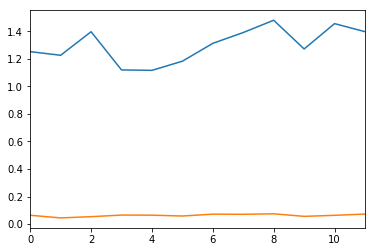

In [39]:
HAT = multiply_case(H, A, T, case)

pd.DataFrame(HAT[:, 0, :]).mean().plot()
pd.DataFrame(HAT[:, 1, :]).mean().plot()


In [28]:
(HAT[:,0,:] - HAT[:, 5, :]).mean()

7.3479842855758744

In [74]:
np.maximum(A[0], np.sum(A[1:], axis=0))

array([[ 15.86742109,   3.98781431],
       [  5.42004517,  13.94392854]])

In [13]:
A[0]

array([[ 15.86742109,   3.98781431],
       [  5.42004517,  13.94392854]])

In [14]:
np.sum(A[1:], axis=0)

array([[ 2.7524587 ,  2.18336352],
       [ 1.8426366 ,  9.76660721]])

In [72]:
A[1]+A[2]+A[3]+A[4]+A[5]+A[6]

array([[ 2.7524587 ,  2.18336352],
       [ 1.8426366 ,  9.76660721]])

In [67]:
A[2]

array([[ 1.79977753,  0.57304481],
       [ 0.92609654,  0.19185062]])

In [26]:
c = 0
for i in range(1, np.shape(tensor)[1]):
    c = c + tensor[:,i,:]/t

array([[[ 0.79949874,  0.84427469,  1.24880615, ...,  0.99938648,
          0.85270758,  0.96486837],
        [ 0.14774213,  0.13712299,  0.2144625 , ...,  0.17341845,
          0.14661051,  0.17769789],
        [ 2.06692459,  2.20702098,  3.24951664, ...,  2.59819651,
          2.21860808,  2.49522803],
        ..., 
        [ 1.17435528,  1.0532045 ,  1.67297836, ...,  1.35654744,
          1.14403785,  1.41129053],
        [ 2.23394172,  1.89144067,  3.08574613, ...,  2.51373834,
          2.11125088,  2.68107815],
        [ 1.20470989,  1.58964702,  2.15577609, ...,  1.69513651,
          1.46911969,  1.46403407]],

       [[ 0.3628244 ,  0.36622884,  0.55212538, ...,  0.44345374,
          0.3771549 ,  0.4373313 ],
        [ 0.06302821,  0.07202621,  0.10316923, ...,  0.08204561,
          0.07039617,  0.07623972],
        [ 0.9405862 ,  0.95657126,  1.43751012, ...,  1.15387719,
          0.98189136,  1.13396662],
        ..., 
        [ 0.47814728,  0.44399393,  0.69426344, ...,

In [28]:
np.shape(tensor)[0]

39

In [69]:

E_np_masked = tensor
HAT = multiply_case(H, A, T, case)
num_appliances = len(A)-1
c = 0
s = 0
for appliance_num in range(1, num_appliances+1):
    gt_appliance_fr = E_np_masked[:, appliance_num, :]/E_np_masked[:, 0, :]
    pred_appliance_fr = HAT[:, appliance_num, :]/E_np_masked[:, 0, :]
    s+= np.isnan(pred_appliance_fr-gt_appliance_fr).sum()
    diff_appliance_fr = (pred_appliance_fr-gt_appliance_fr).flatten()
    diff_appliance_fr = diff_appliance_fr[~np.isnan(diff_appliance_fr)]
    print diff_appliance_fr.shape
    c = c+np.sqrt(np.square(diff_appliance_fr).mean())
    print np.sqrt(np.square(diff_appliance_fr).mean())
print c
print s
c/6

(275,)
0.266403755233
(282,)
0.142128101146
(285,)
0.241081470477
(304,)
0.231143655153
(105,)
0.208568894453
(171,)
0.206473864808
1.29579974127
1386


0.21596662354500892

In [88]:
def cost_fraction2(H, A, T, E_np_masked, case):
    HAT = multiply_case(H, A, T, case)

    gt_appliance_fr = E_np_masked[:, 1:, :]/E_np_masked[:, 0, None,  :]
    pred_appliance_fr = HAT[:, 1:, :]/E_np_masked[:, 0, None, :]
    diff_appliance_fr = (pred_appliance_fr-gt_appliance_fr).flatten()
    diff_appliance_fr = diff_appliance_fr[~np.isnan(diff_appliance_fr)]
    c = np.nan_to_num(np.abs(pred_appliance_fr-gt_appliance_fr)).sum()
    return c

In [64]:
np.isnan(pred_appliance_fr-gt_appliance_fr).sum()

1386

In [48]:
E_np_masked[:, 0, None,  :].shape

(39, 1, 12)

In [36]:
rep = np.repeat(E_np_masked[:, 0, :], 6, axis=0).reshape(39, 6, 12)

In [37]:
np.allclose(rep[:, 0, :], rep[:, 1, :])

False

In [44]:
E_np_masked[:, 1:, :].flatten()/E_np_masked[:, 0, :].flatten()

ValueError: operands could not be broadcast together with shapes (2808,) (468,) 

In [83]:
diff_appliance_fr

array([ 0.22809784,  0.06079369,  0.04206018, ...,  0.07288679,
        0.05714064,  0.04757723])

In [76]:
E_np_masked

array([[[             nan,              nan,   2.20701675e+02, ...,
                      nan,              nan,              nan],
        [             nan,              nan,              nan, ...,
                      nan,              nan,              nan],
        [             nan,              nan,   3.12638664e+01, ...,
                      nan,              nan,              nan],
        ..., 
        [             nan,              nan,   1.23304672e+01, ...,
                      nan,              nan,              nan],
        [             nan,              nan,   9.54773331e+00, ...,
                      nan,              nan,              nan],
        [             nan,              nan,              nan, ...,
                      nan,              nan,              nan]],

       [[             nan,              nan,              nan, ...,
           2.41617935e+02,   2.05790207e+02,   2.90333405e+02],
        [             nan,              nan,              na

In [87]:
np.nan_to_num(np.abs(pred_appliance_fr-gt_appliance_fr)).sum()

240.8002708007852